# 2.多重共線性などを考慮

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys, os
from pathlib import Path
# signalfuncなどのある親ディレクトリのパスを取得,これはJupyter系特有の書き方
current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../')
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

import ml_modules as mm

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from mlxtend.classifier import StackingClassifier
from scipy import interp

/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lightgbm as lgb
import xgboost as xgb

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [7]:
df_train_data = pd.read_csv('../data/wine_train.csv')
df_train_data = pd.get_dummies(df_train_data)

In [8]:
bins = [0,5,7,10]
labels = [0,1,2]

df_train_data['quality_range']=pd.cut(x=df_train_data['quality'], bins=bins, labels=labels)

In [9]:
details = mm.rstr(df_train_data, 'quality')
details

Data shape: (5497, 15)
___________________________
Data types:
 float64    4
int64      3
object     2
dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
fixed.acidity,float64,5497,104,0,0.0,"[5.8, 5.4, 7.4, 7.0, 7.9, 6.1, 5.6, 6.2, 11.9,...",1.732083,5.146521,-0.077304
volatile.acidity,float64,5497,181,0,0.0,"[0.18, 0.835, 0.61, 0.31, 0.35, 0.15, 0.66, 0....",1.480543,2.825178,-0.266449
citric.acid,float64,5497,87,0,0.0,"[0.37, 0.08, 0.01, 0.26, 0.36, 0.29, 0.0, 0.48...",0.355286,1.379355,0.080977
residual.sugar,float64,5497,303,0,0.0,"[1.1, 1.2, 2.0, 7.4, 1.6, 6.2, 2.5, 2.8, 6.9, ...",1.486139,5.006813,-0.041976
chlorides,float64,5497,204,0,0.0,"[0.036000000000000004, 0.046, 0.07400000000000...",5.637169,54.706018,-0.200778
free.sulfur.dioxide,float64,5497,128,0,0.0,"[31.0, 13.0, 28.0, 11.0, 39.0, 7.0, 29.0, 6.0,...",1.298491,9.065928,0.056353
total.sulfur.dioxide,float64,5497,275,0,0.0,"[96.0, 93.0, 38.0, 160.0, 124.0, 151.0, 15.0, ...",0.023181,-0.327189,-0.037969
density,float64,5497,964,0,0.0,"[0.9894200000000001, 0.9924, 0.997479999999999...",0.589583,7.615904,-0.313193
pH,float64,5497,108,0,0.0,"[3.16, 3.57, 3.48, 3.13, 3.25, 3.6, 3.52, 3.33...",0.396733,0.416000,0.009871
sulphates,float64,5497,109,0,0.0,"[0.48, 0.85, 0.65, 0.46, 0.44, 0.58, 0.39, 0.5...",1.881176,9.585108,0.032083


In [17]:
x = df_train_data[list(set(df_train_data.columns)-set(['type_W','type_R','quality','quality_range']))]
# y = df_train_data['quality_range']
y = df_train_data['quality']

ss = StandardScaler()
scaled_x = pd.DataFrame(columns=x.columns,data=ss.fit_transform(x))

## 多重共線性を考慮して線形回帰系を検討

In [11]:
X = sm.add_constant(scaled_x)

In [12]:
corr = X.corr()

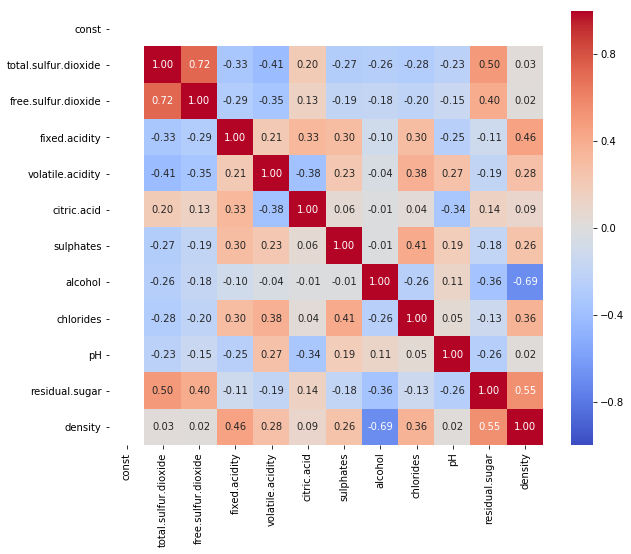

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cbar=True, cmap='coolwarm', square=True, fmt='.2f', ax=ax)

## 重回帰分析の結果から特徴量を選定する
- Adj. R-squared：自由度調整済み決定係数  
回帰式全体の精度,説明力,説明変数が増えると、決定係数(R-squared)は大きくなる.(目標は**0.85**くらい)
- t：各説明変数ごとの統計量  
絶対値が大きければ大きいほど、目的変数に与える影響が大きい.  
constというカラム名は、X = sm.add_constant(x)で生成した『y切片』のことなので、無視
- p>|t|：各説明変数ごとのp値  
0に近づけば近づくほど統計的な意味があり、逆に0.05よりも大きい値であればたまたまである可能性が高い.その説明変数は採用しないほうが良い.

In [14]:
model = smf.OLS(y, X)
result = model.fit()

In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     206.9
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:06:43   Log-Likelihood:                -6117.7
No. Observations:                5497   AIC:                         1.226e+04
Df Residuals:                    5485   BIC:                         1.234e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8234      0.010    585.690      0.000       5.804       5.843
total.sulfur.dioxide    -0.1407      0.017     -8.241      0.000      -0.174      -0.107
free.sulfur.dioxide      0.1080      0.015      7.423      0.000       0.079       0.137
fixed.acidity            0.0926      0.022      4.211      0.000       0.049       0.136
volatile.acidity        -0.2177      0.014    -15.642      0.000      -0.245      -0.190
citric.acid             -0.0210      0.013     -1.654      0.098      -0.046       0.004
sulphates                0.1176      0.012      9.514      0.000       0.093       0.142
alcohol                  0.3177      0.022     14.774      0.000       0.276       0.360
chlorides               -0.0169      0.013     -1.325      0.185      -0.042       0.008
pH                       0.0695      0.016      4.395      0.000       0.038       0.100
residual.sugar           0.2120      0.027      7.971      0.000       0.160       0.264
density                 -0.1770      0.039     -4.483      0.000      -0.254      -0.100
==============================================================================
Omnibus:                      129.434   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.169
Skew:                          -0.009   Prob(JB):                     1.09e-65
Kurtosis:                       4.143   Cond. No.                         9.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
X.drop('total.sulfur.dioxide', axis=1, inplace=True) # alcholと相関が強いので除外してみる

In [17]:
model = smf.OLS(y, X)
result = model.fit()

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     218.1
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:06:44   Log-Likelihood:                -6151.5
No. Observations:                5497   AIC:                         1.232e+04
Df Residuals:                    5486   BIC:                         1.240e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.8234      0.010    582.151      0.000       5.804       5.843
free.sulfur.dioxide     0.0393      0.012      3.278      0.001       0.016       0.063
fixed.acidity           0.0955      0.022      4.320      0.000       0.052       0.139
volatile.acidity       -0.2178      0.014    -15.550      0.000      -0.245      -0.190
citric.acid            -0.0394      0.013     -3.144      0.002      -0.064      -0.015
sulphates               0.1150      0.012      9.253      0.000       0.091       0.139
alcohol                 0.3645      0.021     17.467      0.000       0.324       0.405
chlorides              -0.0048      0.013     -0.374      0.708      -0.030       0.020
pH                      0.0663      0.016      4.166      0.000       0.035       0.097
residual.sugar          0.1591      0.026      6.127      0.000       0.108       0.210
density                -0.1217      0.039     -3.110      0.002      -0.198      -0.045
==============================================================================
Omnibus:                      118.564   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.532
Skew:                          -0.013   Prob(JB):                     9.82e-58
Kurtosis:                       4.070   Cond. No.                         8.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
X.drop('residual.sugar', axis=1, inplace=True) # 他の素性と相関が強いので除外してみる

In [20]:
model = smf.OLS(y, X)
result = model.fit()

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     236.6
Date:                Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:06:47   Log-Likelihood:                -6170.2
No. Observations:                5497   AIC:                         1.236e+04
Df Residuals:                    5487   BIC:                         1.243e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.8234      0.010    580.222      0.000       5.804       5.843
free.sulfur.dioxide     0.0565      0.012      4.830      0.000       0.034       0.079
fixed.acidity          -0.0059      0.015     -0.398      0.691      -0.035       0.023
volatile.acidity       -0.2437      0.013    -18.198      0.000      -0.270      -0.217
citric.acid            -0.0350      0.013     -2.785      0.005      -0.060      -0.010
sulphates               0.0903      0.012      7.652      0.000       0.067       0.113
alcohol                 0.4471      0.016     27.995      0.000       0.416       0.478
chlorides              -0.0246      0.012     -1.991      0.047      -0.049      -0.000
pH                      0.0022      0.012      0.183      0.855      -0.021       0.026
density                 0.0907      0.018      4.972      0.000       0.055       0.126
==============================================================================
Omnibus:                      119.268   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.781
Skew:                           0.014   Prob(JB):                     3.19e-58
Kurtosis:                       4.075   Cond. No.                         3.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X = sm.add_constant(X)

In [23]:
corr = X.corr()

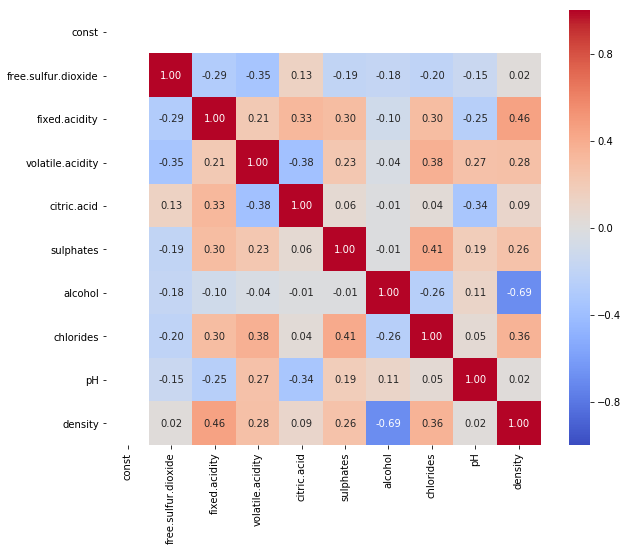

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cbar=True, cmap='coolwarm', square=True, fmt='.2f', ax=ax)

In [12]:
X_train = pd.read_csv('../data/X_train.csv', header=0, index_col=0)
y_train = pd.read_csv('../data/y_train.csv',names=('l'))
X_test = pd.read_csv('../data/X_test.csv', header=0, index_col=0)
y_test = pd.read_csv('../data/y_test.csv',names=('l'))

In [13]:
X_train.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる
X_test.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる

In [14]:
clf = Pipeline([
    ('pca', PCA(random_state = 101)), 
#     ('lda', LDA(store_covariance=True)),
    ('clf', LogisticRegression(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [6, 7, 8]
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]

param_grid =\
    [{'clf__C': C
     ,'clf__solver': ['liblinear', 'saga'] 
     ,'clf__penalty': ['l1', 'l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced']
     ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
},
    {'clf__C': C
     ,'clf__max_iter': [3, 9, 2, 7, 4]
     ,'clf__solver': ['newton-cg', 'sag', 'lbfgs']
     ,'clf__penalty': ['l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced'] 
#      ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
     
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
LR = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [15]:
LR.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   39.6s finished
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  51.36% 
Precision: 49.24% 
Recall:    51.36% 
F1 Score:  44.61% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.48      0.76      0.59       473
           7       0.56      0.03      0.05       200
           5       0.57      0.58      0.57       351
           8       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.51      0.51      0.51      1100
   macro avg       0.23      0.19      0.17      1100
weighted avg       0.49      0.51      0.45      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   6  7    5  8  4  3  9
Actual: 6        358  1  114  0  0  0  0
        7        187  5 

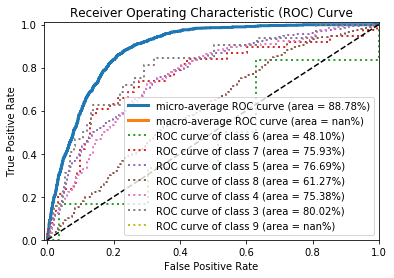

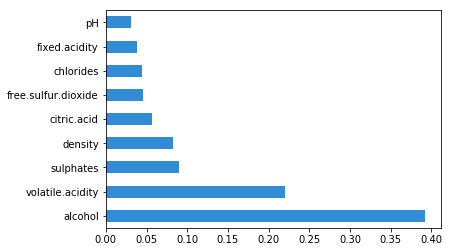

In [19]:
results = mm.get_results(LR,'LogisticRegression', X_test, y_test['l'], gs = gs,target_labels=y.unique(),target_names=[str(x) for x in y.unique()], reasume=True)

In [20]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.5136,0.593812,NaN


In [21]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', DecisionTreeClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11,] # 15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None] 

param_grid =\
    [{ 'clf__class_weight': class_weight
      ,'clf__criterion': criterion
      ,'clf__splitter': splitter
      ,'clf__max_depth': max_depth
      ,'clf__min_samples_leaf': min_samples_leaf
#       ,'lda__n_components': n_components
#       ,'pca__n_components': n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [22]:
DT.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.4s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  52.73% 
Precision: 50.78% 
Recall:    52.73% 
F1 Score:  50.88% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.52      0.66      0.58       473
           7       0.48      0.36      0.41       200
           5       0.57      0.55      0.56       351
           8       0.12      0.03      0.05        32
           4       0.29      0.05      0.09        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.53      0.53      0.53      1100
   macro avg       0.28      0.24      0.24      1100
weighted avg       0.51      0.53      0.51      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   6   7    5  8  4  3  9
Actual: 6        313  48  110  2  0  0  0
        7        114 

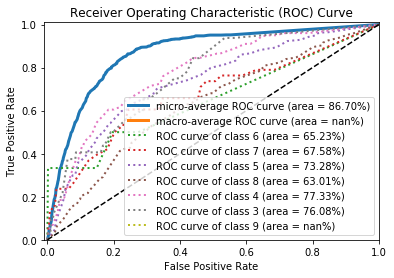

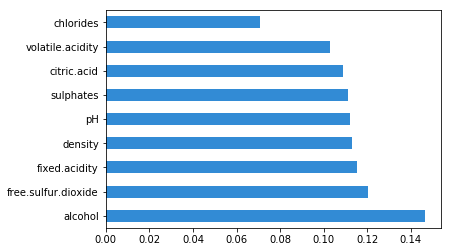

In [23]:
results = mm.get_results(DT, 'DT First', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],target_labels=y.unique(), results=results, reasume=False)

In [24]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.5136,0.593812,NaN
DT First,True,0.5273,0.626935,NaN


In [25]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)), 
    ('pca', PCA(random_state = 101)),
    ('clf', SVC(random_state=101, kernel='linear', probability=True))])   

# a list of dictionaries to specify the parameters that we'd want to tune
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
gamma = ['scale', 'auto']


param_grid =\
    [{'clf__C': C
     ,'clf__tol' : tol 
     ,'clf__class_weight': class_weight
#      ,'lda__n_components': n_components
#      ,'pca__n_components' : n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
svc = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [26]:
svc.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   51.6s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  50.45% 
Precision: 38.31% 
Recall:    50.45% 
F1 Score:  43.14% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.48      0.75      0.58       473
           7       0.00      0.00      0.00       200
           5       0.55      0.58      0.56       351
           8       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50      1100
   macro avg       0.15      0.19      0.16      1100
weighted avg       0.38      0.50      0.43      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   6  7    5  8  4  3  9
Actual: 6        353  0  120  0  0  0  0
        7        185  0 

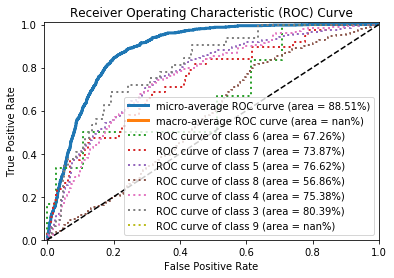

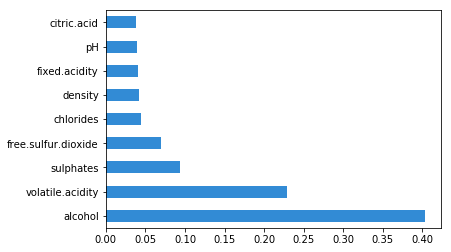

In [27]:
results = mm.get_results(svc,'LinearSVC', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],target_labels=y.unique(),results=results, reasume=False)

In [28]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.5136,0.593812,NaN
DT First,True,0.5273,0.626935,NaN
LinearSVC,True,0.5045,0.586540,NaN


In [29]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', RandomForestClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
SEL = X_train.columns
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None] #, 3, 4, 5, 10] # 
min_samples_split = [2, 3, 4]
min_samples_leaf = [1] #, 2 , 3]

param_grid =\
    [{ 'clf__class_weight': class_weight,
      'clf__criterion': criterion
      ,'clf__n_estimators': n_estimators      
      ,'clf__min_samples_split': min_samples_split
      ,'clf__max_depth': max_depth
#       ,'lda__n_components':n_components
#       ,'pca__n_components':n_components
#       ,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
RF = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [30]:
RF.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.2min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  65.45% 
Precision: 66.18% 
Recall:    65.45% 
F1 Score:  63.98% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.75      0.68       473
           7       0.68      0.49      0.57       200
           5       0.68      0.72      0.70       351
           8       0.79      0.34      0.48        32
           4       0.67      0.05      0.10        38
           3       1.00      0.17      0.29         6
           9       0.00      0.00      0.00         0

   micro avg       0.65      0.65      0.65      1100
   macro avg       0.63      0.36      0.40      1100
weighted avg       0.66      0.65      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        355  33   83   1  1  0  0
        7         

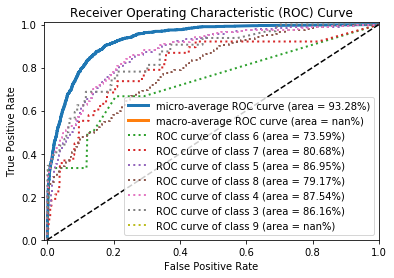

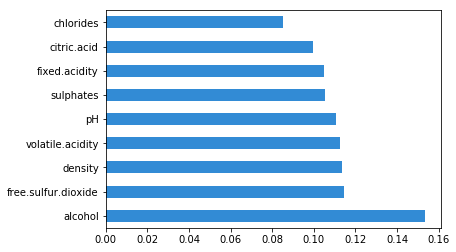

In [31]:
results = mm.get_results(RF, 'RF', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()], target_labels=y.unique(), results=results, reasume=False)

In [34]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', KNeighborsClassifier())])

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]

param_grid =\
    [{
     'clf__n_neighbors': [19, 20,21,22,23,24,25,26,27,28,29,30] 
     ,'clf__weights': ['distance'] 
     ,'clf__algorithm' : ['ball_tree', 'brute', 'auto',  'kd_tree', 'brute']
     ,'clf__leaf_size': [12, 11, 13]
     ,'clf__p': [1] 
#      ,'lda__n_components' : n_components
#      ,'pca__n_components' : n_components
#      ,'pca__whiten' : whiten
     }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

KNNC = Pipeline([
#         ('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [35]:
KNNC.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 695 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.2min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

In [194]:
# file_knn = '../model/KNN.pickle'

In [195]:
# with open(file_knn, mode='wb') as fp:
#     pickle.dump(KNNC, fp, protocol=2)

Model Performance metrics:
------------------------------
Accuracy:  65.55% 
Precision: 67.27% 
Recall:    65.55% 
F1 Score:  64.00% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.62      0.76      0.68       473
           7       0.67      0.51      0.58       200
           5       0.69      0.71      0.70       351
           8       1.00      0.34      0.51        32
           4       1.00      0.05      0.10        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.57      0.34      0.37      1100
weighted avg       0.67      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                       
                   6    7    5   8  4  3  9
Actual: 6        358   37   78   0  0  0  0
        7      

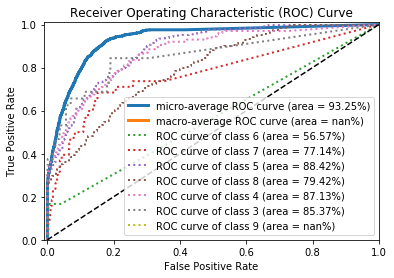

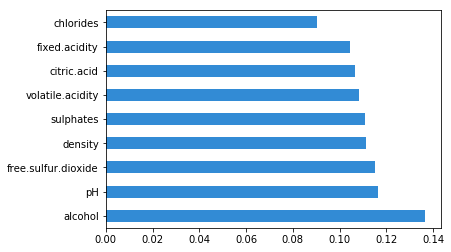

In [36]:
results = mm.get_results(KNNC, 'KNeighborsClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],
                      target_labels=y.unique(),results=results, reasume=False)

In [37]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.5136,0.593812,NaN
DT First,True,0.5273,0.626935,NaN
LinearSVC,True,0.5045,0.586540,NaN
RF,True,0.6545,0.724859,NaN
KNeighborsClassifier,True,0.6555,0.724781,NaN


In [38]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', lgb.LGBMClassifier(objective='multiclass',
                        num_leaves = 31,
                        learning_rate=0.1,
                        min_child_samples=10,
                        n_estimators=100))])  

# a list of dictionaries to specify the parameters that we'd want to tune
SEL = X_train.columns
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None] #, 3, 4, 5, 10] # 
min_samples_split = [2, 3, 4]
min_samples_leaf = [1] #, 2 , 3]

param_grid =\
    [{ #'clf__class_weight': class_weight
      'clf__criterion': criterion
      ,'clf__n_estimators': n_estimators      
      ,'clf__min_samples_split': min_samples_split
      ,'clf__max_depth': max_depth
      #,'clf__min_samples_leaf': min_samples_leaf
#       ,'lda__n_components' : n_components
#       ,'pca__n_components' : n_components
      #,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
GBM = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [39]:
GBM.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  63.00% 
Precision: 62.37% 
Recall:    63.00% 
F1 Score:  61.50% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.61      0.70      0.65       473
           7       0.62      0.48      0.54       200
           5       0.66      0.72      0.69       351
           8       0.71      0.31      0.43        32
           4       0.50      0.05      0.10        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63      1100
   macro avg       0.44      0.32      0.34      1100
weighted avg       0.62      0.63      0.62      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        331  41   98   1  2  0  0
        7         

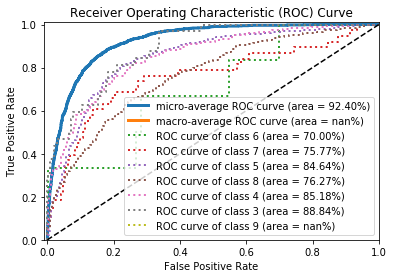

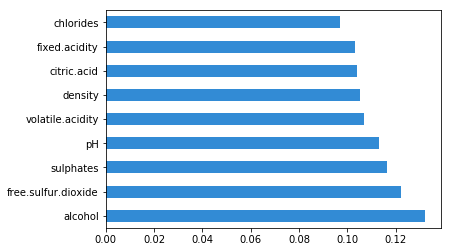

In [70]:
results = mm.get_results(GBM, 'LGBM', X_test, y_test['l'], gs = gs, target_names = [str(x) for x in y.unique()], target_labels = y.unique(), results=results, reasume=False)

In [71]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.4982,0.583735,NaN
DT First,True,0.5218,0.624115,NaN
LinearSVC,True,0.4982,0.582284,NaN
RF,True,0.6482,0.716774,NaN
KNeighborsClassifier,True,0.6555,0.724781,NaN
LGBM,True,0.6300,0.708668,NaN


In [72]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, n_jobs=1,
                       colsample_bytree=1, gamma=0.0001, max_delta_step=0, random_state=101, 
                       silent=True, subsample=1))])
n_est = [112] #112
max_depth = [15] 
learning_rate = [0.1] 
reg_lambda = [0.7] 
reg_alpha= [0.05]
booster = ['gbtree'] #  'dart'] #,'gblinear',
objective = ['multi:softmax'] #, 'multi:softprob']

param_grid =\
    [{ 
      'clf__n_estimators': n_est
      ,'clf__booster': booster
      ,'clf__objective': objective
      ,'clf__learning_rate': learning_rate
      ,'clf__reg_lambda': reg_lambda
      ,'clf__reg_alpha': reg_alpha
      ,'clf__max_depth': max_depth
#       ,'lda__n_components' : n_components
    ,'pca__n_components' : n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3,
                  verbose=1, n_jobs=3)

XGBC = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [73]:
XGBC.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   28.9s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=3, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  63.73% 
Precision: 63.27% 
Recall:    63.73% 
F1 Score:  62.24% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.61      0.72      0.66       473
           7       0.61      0.46      0.52       200
           5       0.68      0.72      0.70       351
           8       0.67      0.31      0.43        32
           4       0.50      0.05      0.10        38
           3       0.50      0.17      0.25         6
           9       0.00      0.00      0.00         0

   micro avg       0.64      0.64      0.64      1100
   macro avg       0.51      0.35      0.38      1100
weighted avg       0.63      0.64      0.62      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        342  41   89   0  0  1  0
        7         

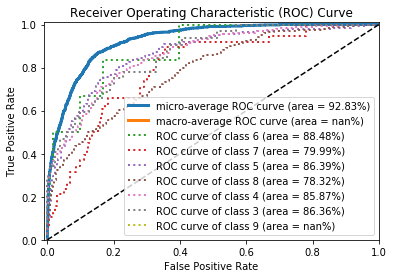

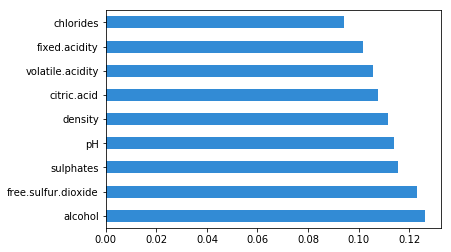

In [74]:
results = mm.get_results(XGBC, 'XGBC', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()], target_labels=y.unique(),results=results,reasume=False)

In [75]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', GradientBoostingClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
#cv=None, dual=False,  scoring=None, refit=True,  multi_class='ovr'
SEL = X_train.columns
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
# whiten = [True, False]
learning_rate =  [1e-02] #, 5e-03, 2e-02]
n_estimators= [400]
max_depth = [10]
n_comp = [2, 3, 4, 5]

param_grid =\
    [{'clf__learning_rate': learning_rate
     ,'clf__max_depth': max_depth
     ,'clf__n_estimators' : n_estimators 
      ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components
     #,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

GBC = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        ('gs', gs)
 ])  

In [76]:
GBC.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.9min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  64.00% 
Precision: 64.30% 
Recall:    64.00% 
F1 Score:  62.68% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.61      0.74      0.67       473
           7       0.61      0.46      0.52       200
           5       0.69      0.70      0.70       351
           8       0.62      0.31      0.42        32
           4       0.67      0.11      0.18        38
           3       1.00      0.17      0.29         6
           9       0.00      0.00      0.00         0

   micro avg       0.64      0.64      0.64      1100
   macro avg       0.60      0.36      0.40      1100
weighted avg       0.64      0.64      0.63      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        351  37   83   2  0  0  0
        7        1

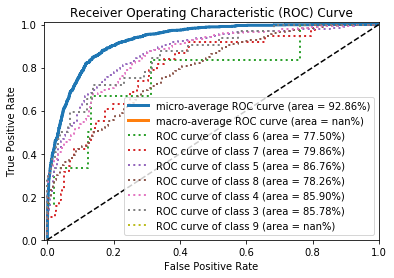

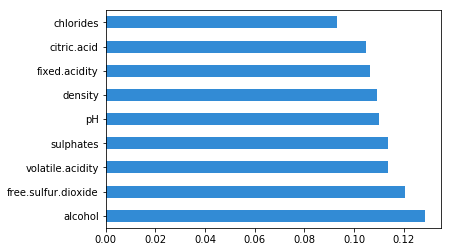

In [77]:
results = mm.get_results(GBC, 'GradientBoostingClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()]
                      ,target_labels=y.unique(), results=results, reasume=False)

In [80]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', AdaBoostClassifier(random_state=101))])

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]

param_grid =\
    [{'clf__learning_rate': [2e-01, 15e-02]
     ,'clf__n_estimators': [500, 600, 700] 
     ,'clf__algorithm' : ['SAMME.R'] # 'SAMME'
     ,'pca__n_components' : n_components
     #,'pca__whiten' : whiten
#      ,'lda__n_components': n_components
      ,'pca__n_components': n_components
     }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

ADAB = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        #('lda', LDA(store_covariance=True)),
        ('gs', gs)
 ])  

In [81]:
ADAB.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  22.18% 
Precision: 38.61% 
Recall:    22.18% 
F1 Score:  24.55% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.45      0.35      0.39       473
           7       0.45      0.20      0.28       200
           5       0.33      0.04      0.07       351
           8       0.01      0.06      0.02        32
           4       0.06      0.63      0.11        38
           3       0.03      0.17      0.05         6
           9       0.00      0.00      0.00         0

   micro avg       0.22      0.22      0.22      1100
   macro avg       0.19      0.21      0.13      1100
weighted avg       0.39      0.22      0.25      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                        
                   6   7   5   8    4   3  9
Actual: 6        164  34  21  88  155  11  0
        7   

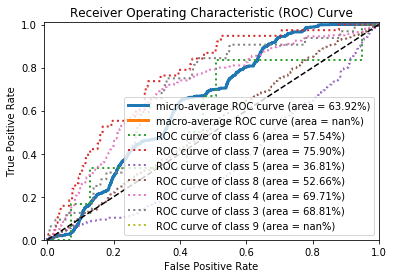

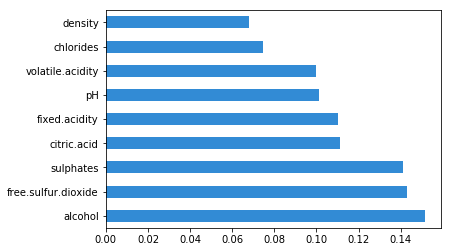

In [82]:
results = mm.get_results(ADAB, 'AdaBoostClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()]
                      ,target_labels=y.unique(), results=results, reasume=False)

In [83]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.4982,0.583735,NaN
DT First,True,0.5218,0.624115,NaN
LinearSVC,True,0.4982,0.582284,NaN
RF,True,0.6482,0.716774,NaN
KNeighborsClassifier,True,0.6555,0.724781,NaN
LGBM,True,0.6300,0.708668,NaN
XGBC,True,0.6373,0.713930,NaN
GradientBoostingClassifier,True,0.6400,0.715124,NaN
AdaBoostClassifier,True,0.2218,0.524381,NaN


In [64]:
estimators = [
    ('GBC', GBC),
    ('rf', RF),
    ('knn', KNNC),
    ('gbm', GBM),
    ('xgb', XGBC),
    ('lr', LR),
    ('adab', ADAB),
    ('svc', svc)
    ]

In [224]:
voting = VotingClassifier(estimators,weights=[1.5, 2, 1.5, 1.5, 1, 0.5, 0.5, 0.5], voting='soft')

In [225]:
voting.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.4s finished


Fitting 5 folds for each of 228 candidates, totalling 1140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1140 out of 1140 | elapsed:   30.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.4s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   57.2s finished


VotingClassifier(estimators=[('GBC',
                              Pipeline(memory=None,
                                       steps=[('scl',
                                               StandardScaler(copy=True,
                                                              with_mean=True,
                                                              with_std=True)),
                                              ('gs',
                                               GridSearchCV(cv=5,
                                                            error_score='raise-deprecating',
                                                            estimator=Pipeline(memory=None,
                                                                               steps=[('pca',
                                                                                       PCA(copy=True,
                                                                                           iterated_power='auto',
             

In [231]:
filename = '../model/pca_rm_multico_voting_model.pickle'

In [232]:
with open(filename, mode='wb') as fp:
    pickle.dump(voting, fp, protocol=2)

Model Performance metrics:
------------------------------
Accuracy:  66.09% 
Precision: 67.93% 
Recall:    66.09% 
F1 Score:  64.46% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.76      0.69       473
           7       0.67      0.48      0.56       200
           5       0.70      0.74      0.71       351
           8       0.83      0.31      0.45        32
           4       1.00      0.05      0.10        38
           3       1.00      0.17      0.29         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.69      0.36      0.40      1100
weighted avg       0.68      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        360  32   81   0  0  0  0
        7         

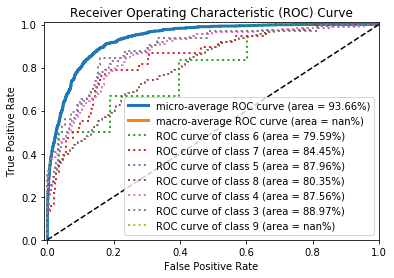

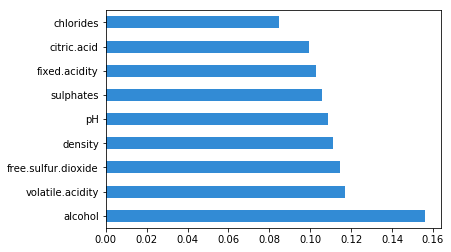

In [233]:
results = mm.get_results(voting, 'voting', X_test, y_test['l'], target_labels = y.unique(), target_names=[str(x) for x in y.unique()],results=results, reasume=False)

In [235]:
print(results)
results.to_csv('../data/pca_rm_multico_results.csv')

                            Prob  Accuracy  ROC AUC Score  ROC Area
LogisticRegression          True    0.5209       0.601192       NaN
DT First                    True    0.5136       0.611250       NaN
LinearSVC                   True    0.5227       0.600052       NaN
RF                          True    0.6573       0.724433       NaN
KNeighborsClassifier        True    0.6418       0.711360       NaN
LGBM                        True    0.6264       0.706376       NaN
XGBC                        True    0.6391       0.718318       NaN
GradientBoostingClassifier  True    0.6373       0.714087       NaN
AdaBoostClassifier          True    0.2745       0.567908       NaN
voting                      True    0.6609       0.729267       NaN
